#### **Importing libraries and data**

In [1]:
import shap
import csv
import math
import pickle
import datetime as dt
import pandas as pd
import numpy as np
import sklearn
import time
import warnings
warnings.filterwarnings('ignore')

from scipy import stats
from dateutil.parser import parse
from datetime import datetime
from sklearn.model_selection import train_test_split, GroupKFold, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error
from catboost import CatBoostRegressor, Pool
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
plt.style.use('fivethirtyeight')
pd.options.display.float_format = '{:.2f}'.format

In [2]:
# Model Evaluation metrics calculation

# calculate rmse scores
def rmse(pred_test, y_test):
    return np.sqrt(((pred_test - y_test) ** 2).mean())

# calculate mape scores
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# create union of the list the 4 lists provided
def do_union(lst1, lst2): 
    final_list = list(set(lst1) | set(lst2))
    return final_list 

In [3]:
# Load analytical dataset using name and path
load_ads = pd.read_csv('gs://aes-analytics-0002-curated/Outage_Restoration/Repredictions/Master_Dataset/OMS_IPL_Repredictions_V2_12122020.csv', index_col=0)

# reset the index column to start from zero
load_ads.reset_index(drop=True, inplace=True)

# print shape of the dataset
print(load_ads.shape)

# display the dataset
load_ads.head()

(488771, 155)


,OUTAGE_ID,INCIDENT_ID,STRCTUR_NO,CREATION_DATETIME,ENERGIZED_DATETIME,CIRCT_ID,DNI_EQUIP_TYPE,SUBST_ID,CALL_QTY,DOWNSTREAM_CUST_QTY,KEY_CUST_QTY,ETR_DATETIME,CUST_QTY,DAY_FLAG,POLE_CLUE_FLG,PART_LIGHT_CLUE_FLG,EMERGENCY_CLUE_FLG,POWER_OUT_CLUE_FLG,OPEN_DEVICE_CLUE_FLG,TREE_CLUE_FLG,WIRE_DOWN_CLUE_FLG,IVR_CLUE_FLG,EQUIPMENT_CLUE_FLG,TRANSFORMER_CLUE_FLG,OH_CAUSE_FLG,UG_CAUSE_FLG,ANIMAL_CAUSE_FLG,WEATHER_CAUSE_FLG,WEATHER_COLD_CAUSE_FLG,PUBLIC_CAUSE_FLG,WEATHER_LIGHTNING_CAUSE_FLG,WEATHER__SNOW_CAUSE_FLG,WEATHER__WIND_CAUSE_FLG,WEATHER__HEAT_CAUSE_FLG,CUST_REQUEST_CAUSE_FLG,WEATHER__FLOOD_CAUSE_FLG,STREET_CAUSE_FLG,SUBSTATION_CAUSE_FLG,TREE_CAUSE_FLG,MISCELLANEOUS_CAUSE_FLG,NO_CAUSE_FLG,PLANNED_CAUSE_FLG,NO_OUTAGE_CAUSE_FLG,FUSE_OCCURN_FLG,CUST_EQUIP_OCCURN_FLG,POLE_OCCURN_FLG,TRANSFORMER_OCCURN_FLG,METER_OCCURN_FLG,SERVICE_OCCURN_FLG,CABLE_OCCURN_FLG,ST_OCCURN_FLG,FIRE_OCCURN_FLG,FOUND_OPEN_OCCURN_FLG,PUBLIC_SAFETY_OCCURN_FLG,WIRE_OCCURN_FLG,SWITCH_OCCURN_FLG,REGULATOR_OCCURN_FLG,CUTOUT_OCCURN_FLG,CAP_BANK_OCCURN_FLG,RECLOSER_OCCURN_FLG,OH_OCCURN_FLG,PRIORITY_VAL_1.0,PRIORITY_VAL_2.0,PRIORITY_VAL_3.0,PRIORITY_VAL_5.0,CITY_NAM,ZONE,NO_OF_POWER_OUT_CLUE_PER_DAY,NO_OF_OPEN_DEVICE_CLUE_PER_DAY,NO_OF_IVR_CLUE_PER_DAY,NO_OF_ANIMAL_CAUSE_PER_DAY,NO_OF_WIRE_OCCURN_PER_DAY,Hour_Sin,Hour_Cos,LIVE_OUTAGE,Weekday,Weekend_flag,Priority_Customer_Qty,Priority_Dist_Customer_Qty,Dispatch_Location,cldCvrAvg,cldCvrMax,cldCvrMin,dewPtAvg,dewPtMax,dewPtMin,feelsLikeAvg,feelsLikeMax,feelsLikeMin,heatIndexAvg,heatIndexMax,heatIndexMin,mslPresAvg,mslPresMax,mslPresMin,precip,radSolarAvg,radSolarMax,radSolarTot,relHumAvg,relHumMax,relHumMin,sfcPresAvg,sfcPresMax,sfcPresMin,snowfall,spcHumAvg,spcHumMax,spcHumMin,tempAvg,tempMax,tempMin,wetBulbAvg,wetBulbMax,wetBulbMin,windChillAvg,windChillMax,windChillMin,windDir100mAvg,windDir80mAvg,windDirAvg,windSpd100mAvg,windSpd100mMax,windSpd100mMin,windSpd80mAvg,windSpd80mMax,windSpd80mMin,windSpdAvg,windSpdMax,windSpdMin,tempRange,windSpdRange,sfcPresRange,cldCvrRange,relHumRange,relHumRatio,sfcPresRatio,Time_Since_Outage,TR,REP_OUTAGE_ID,Outages_in_last_1hr,Outages_in_last_2hr,Outages_in_last_3hr,Outages_in_last_4hr,Outages_in_last_5hr,Outages_in_last_6hr,Outages_in_last_7hr,Outages_in_last_8hr,Outages_in_last_9hr,Outages_in_last_10hr,Slope_outages,Slope_ROC_outages,max_ROC_outages,max_index_ROC,weight_ROC
0,2001309379,2000383864.00,494-B/403,2007-01-01 08:16:14,2007-01-01 10:04:24,1252.00,FUSE,125.00,1,5.00,0.00,2007-01-01 11:46:14,5.00,True,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,INDIANAPOLIS,ZONE4,7,3,5,2,1,0.87,-0.50,0,Monday,False,2.00,2.00,MILL,93.00,100.00,43.00,33.20,39.10,29.50,29.60,36.30,23.50,37.90,43.20,34.00,1016.90,1026.20,1009.30,0.00,29.00,127.20,695.30,83.00,90.00,79.00,986.80,995.70,980.10,0.00,4.10,5.20,3.50,37.90,43.20,34.00,36.00,41.30,32.20,29.60,36.30,23.50,270.00,271.00,268.00,16.80,20.20,8.70,16.90,20.50,8.80,14.40,17.80,6.70,9.20,11.10,15.60,57.00,11.00,1.14,1.02,13.77,94.40,200130937901 08:30,0,0,0,0,1,1,1,1,1,1,5.00,-1.13,1,4,0.40
1,2001309379,2000383864.00,494-B/403,2007-01-01 08:16:14,2007-01-01 10:04:24,1252.00,FUSE,125.00,1,5.00,0.00,2007-01-01 11:46:14,5.00,True,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,INDIANAPOLIS,ZONE4,7,3,5,2,1,0.87,-0.50,0,Monday,False,2.00,2.00,MILL,93.00,100.00,43.00,33.20,39.10,29.50,29.60,36.30,23.50,37.90,43.20,34.00,1016.90,1026.20,1009.30,0.00,29.00,127.20,695.30,83.00,90.00,79.00,986.80,995.70,980.10,0.00,4.10,5.20,3.50,37.90,43.20,34

In [4]:
print(list(load_ads.columns))

['OUTAGE_ID', 'INCIDENT_ID', 'STRCTUR_NO', 'CREATION_DATETIME', 'ENERGIZED_DATETIME', 'CIRCT_ID', 'DNI_EQUIP_TYPE', 'SUBST_ID', 'CALL_QTY', 'DOWNSTREAM_CUST_QTY', 'KEY_CUST_QTY', 'ETR_DATETIME', 'CUST_QTY', 'DAY_FLAG', 'POLE_CLUE_FLG', 'PART_LIGHT_CLUE_FLG', 'EMERGENCY_CLUE_FLG', 'POWER_OUT_CLUE_FLG', 'OPEN_DEVICE_CLUE_FLG', 'TREE_CLUE_FLG', 'WIRE_DOWN_CLUE_FLG', 'IVR_CLUE_FLG', 'EQUIPMENT_CLUE_FLG', 'TRANSFORMER_CLUE_FLG', 'OH_CAUSE_FLG', 'UG_CAUSE_FLG', 'ANIMAL_CAUSE_FLG', 'WEATHER_CAUSE_FLG', 'WEATHER_COLD_CAUSE_FLG', 'PUBLIC_CAUSE_FLG', 'WEATHER_LIGHTNING_CAUSE_FLG', 'WEATHER__SNOW_CAUSE_FLG', 'WEATHER__WIND_CAUSE_FLG', 'WEATHER__HEAT_CAUSE_FLG', 'CUST_REQUEST_CAUSE_FLG', 'WEATHER__FLOOD_CAUSE_FLG', 'STREET_CAUSE_FLG', 'SUBSTATION_CAUSE_FLG', 'TREE_CAUSE_FLG', 'MISCELLANEOUS_CAUSE_FLG', 'NO_CAUSE_FLG', 'PLANNED_CAUSE_FLG', 'NO_OUTAGE_CAUSE_FLG', 'FUSE_OCCURN_FLG', 'CUST_EQUIP_OCCURN_FLG', 'POLE_OCCURN_FLG', 'TRANSFORMER_OCCURN_FLG', 'METER_OCCURN_FLG', 'SERVICE_OCCURN_FLG', 'CABLE_

In [5]:
# converting data type of CIRCT_ID & SUBST_ID to integer as it will passed as categorical column in catboost cat index
load_ads['CIRCT_ID'] = load_ads['CIRCT_ID'].astype(int)
load_ads['SUBST_ID'] = load_ads['SUBST_ID'].astype(int)

# create year columns
load_ads['CREATION_DATETIME'] = pd.to_datetime(load_ads['CREATION_DATETIME'], errors='coerce')
load_ads['Year'] = load_ads['CREATION_DATETIME'].dt.year

# drop unneccessary columns
load_ads_v1 = load_ads.copy(deep=True)
load_ads_v1.drop(columns=['OUTAGE_ID', 'INCIDENT_ID', 'CREATION_DATETIME', 'ENERGIZED_DATETIME',
                          'ETR_DATETIME', 'LIVE_OUTAGE', 'REP_OUTAGE_ID', 'Year', 'CUST_QTY', 'KEY_CUST_QTY'], inplace=True)

# delete previous dataframe which is in memory
# del load_ads

#### **Feature Selection using CatBoost Model & Light GBM Models**

In [6]:
# creating variable with having only categorical features index
categorical_features_indices = np.where((load_ads_v1.drop(['TR'],axis=1).dtypes != np.int) & (load_ads_v1.drop(['TR'],axis=1).dtypes != np.float))[0];

# adding Substation id and Circuit id as categorical feature
arr1 = np.array([1, 3])
categorical_features_indices = np.append(arr1, categorical_features_indices)
print(categorical_features_indices)

# pretty printing
print('\n')

# create columns names
column_names = list(load_ads_v1.columns[categorical_features_indices])
print(column_names)

[ 1  3  0  2  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49
 50 51 52 53 54 55 56 57 58 59 67 68 71]


['CIRCT_ID', 'SUBST_ID', 'STRCTUR_NO', 'DNI_EQUIP_TYPE', 'DAY_FLAG', 'POLE_CLUE_FLG', 'PART_LIGHT_CLUE_FLG', 'EMERGENCY_CLUE_FLG', 'POWER_OUT_CLUE_FLG', 'OPEN_DEVICE_CLUE_FLG', 'TREE_CLUE_FLG', 'WIRE_DOWN_CLUE_FLG', 'IVR_CLUE_FLG', 'EQUIPMENT_CLUE_FLG', 'TRANSFORMER_CLUE_FLG', 'OH_CAUSE_FLG', 'UG_CAUSE_FLG', 'ANIMAL_CAUSE_FLG', 'WEATHER_CAUSE_FLG', 'WEATHER_COLD_CAUSE_FLG', 'PUBLIC_CAUSE_FLG', 'WEATHER_LIGHTNING_CAUSE_FLG', 'WEATHER__SNOW_CAUSE_FLG', 'WEATHER__WIND_CAUSE_FLG', 'WEATHER__HEAT_CAUSE_FLG', 'CUST_REQUEST_CAUSE_FLG', 'WEATHER__FLOOD_CAUSE_FLG', 'STREET_CAUSE_FLG', 'SUBSTATION_CAUSE_FLG', 'TREE_CAUSE_FLG', 'MISCELLANEOUS_CAUSE_FLG', 'NO_CAUSE_FLG', 'PLANNED_CAUSE_FLG', 'NO_OUTAGE_CAUSE_FLG', 'FUSE_OCCURN_FLG', 'CUST_EQUIP_OCCURN_FLG', 'POLE_OCCURN_FLG', 'TRANSFORMER_OCCURN_FLG', 'METER_OCC

In [7]:
%%time

# feature selection using catboost
X = load_ads_v1.drop(['TR'],axis=1)
y = load_ads_v1['TR']

cat = CatBoostRegressor(silent = True)
cat.fit(X, y, cat_features=categorical_features_indices)

catboost = pd.DataFrame({'Features': X.columns, 'Importance_Score_CatBoost': cat.feature_importances_}).sort_values(by='Importance_Score_CatBoost',ascending=False)
catboost.reset_index(drop=True,inplace=True)
catboost = catboost.head(40)

CPU times: user 37min 14s, sys: 2min 59s, total: 40min 13s
Wall time: 5min 34s


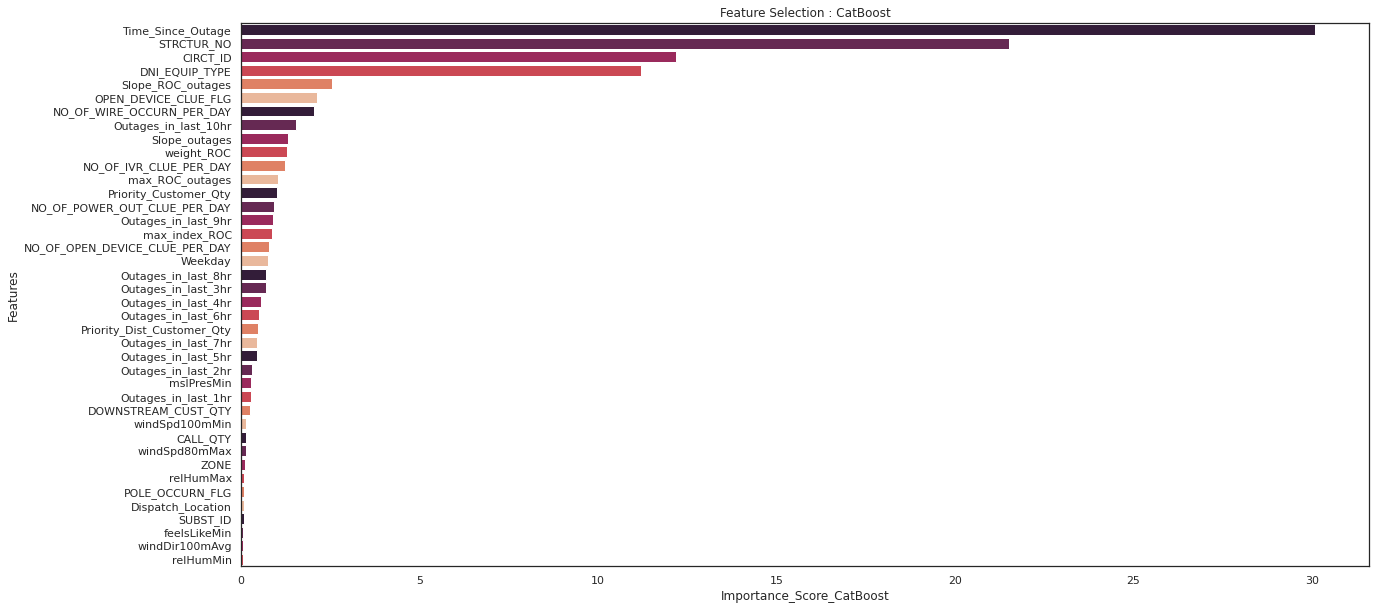

In [8]:
sns.set(rc={'figure.figsize':(18,10)})
sns.set_style("white")
ax = sns.barplot(x="Importance_Score_CatBoost", y="Features", data=catboost, palette=sns.color_palette("rocket")).set_title('Feature Selection : CatBoost')

In [9]:
final_features = list(catboost.Features)

In [10]:
catboost.to_csv('gs://aes-analytics-0002-curated/Outage_Restoration/Repredictions/Model/IPL_TTR_Catboost_12142020.csv', index=False)

#### **Defining the Baseline model & Interpretation**

In [11]:
# creating variable with having only categorical features index
categorical_features_indices = np.where((X[final_features].dtypes != np.int) & (X[final_features].dtypes != np.float))[0];

# adding Substation id and Circuit id as categorical feature
arr1 = np.array([2, 36])
categorical_features_indices = np.append(arr1, categorical_features_indices)
print(categorical_features_indices)

[ 2 36  1  3  5 17 32 34 35]


In [12]:
%%time

model = CatBoostRegressor(one_hot_max_size=10, iterations=500, silent=True, loss_function = 'MAE', eval_metric = 'RMSE')
model.fit(X[final_features], y, cat_features=categorical_features_indices, early_stopping_rounds=50)

CPU times: user 11min 9s, sys: 1min 14s, total: 12min 23s
Wall time: 1min 47s


#### **Baseline Model Interpretation using SHAP**

SHAP (SHapley Additive exPlanations) is a game theoretic approach to explain the output of any machine learning model. <br>
It connects optimal credit allocation with local explanations using the classic Shapley values from game theory and their related extensions (see papers for details and citations). <br>

In [13]:
# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn and spark models)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X[final_features])

# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
shap.force_plot(explainer.expected_value, shap_values[0,:], X[final_features].iloc[0,:])

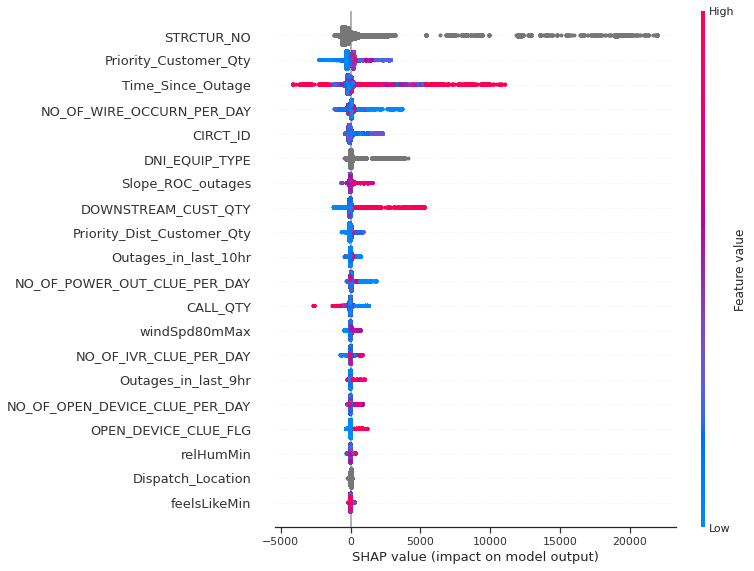

In [14]:
shap_values = model.get_feature_importance(Pool(X[final_features], label=y,cat_features=categorical_features_indices), type="ShapValues")
shap_values = shap_values[:,:-1]

# summarize the effects of all the features
sns.set(rc={'figure.figsize':(18,10)})
sns.set_style("white")
shap.summary_plot(shap_values, X[final_features])

In [15]:
def log_loss(m, X, y): 
    return metrics.log_loss(y,m.predict_proba(X)[:,1])
    
def permutation_importances(model, X, y, metric):
    baseline = metric(model, X, y)
    imp = []
    for col in X.columns:
        save = X[col].copy()
        X[col] = np.random.permutation(X[col])
        m = metric(model, X, y)
        X[col] = save
        imp.append(m-baseline)
    return np.array(imp)

In [16]:
def get_feature_imp_plot(method):
    
    if method == "Permutation":
        fi =  permutation_importances(model, X[final_features], y, log_loss)
    
    elif method == "ShapeValues":
        shap_values = model.get_feature_importance(Pool(X[final_features], label=y, cat_features=categorical_features_indices), type="ShapValues")
        shap_values = shap_values[:,:-1]
        shap.summary_plot(shap_values, X) 
        
    else:
        fi = model.get_feature_importance(Pool(X[final_features], label=y, cat_features=categorical_features_indices), type=method)
        
    if method != "ShapeValues":
        feature_score = pd.DataFrame(list(zip(X[final_features].dtypes.index, fi )), columns=['Feature','Score'])

        feature_score.sort_values(by='Score', ascending=False, inplace=True, kind='quicksort', na_position='last')
        sns.set(rc={'figure.figsize':(18,10)})
        sns.set_style("white")
        ax = sns.barplot(x="Score", y="Feature", data=feature_score, palette=sns.diverging_palette(150, 275, s=80, l=55, n=9)).set_title('Feature Selection using CatBoost')

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.91 µs


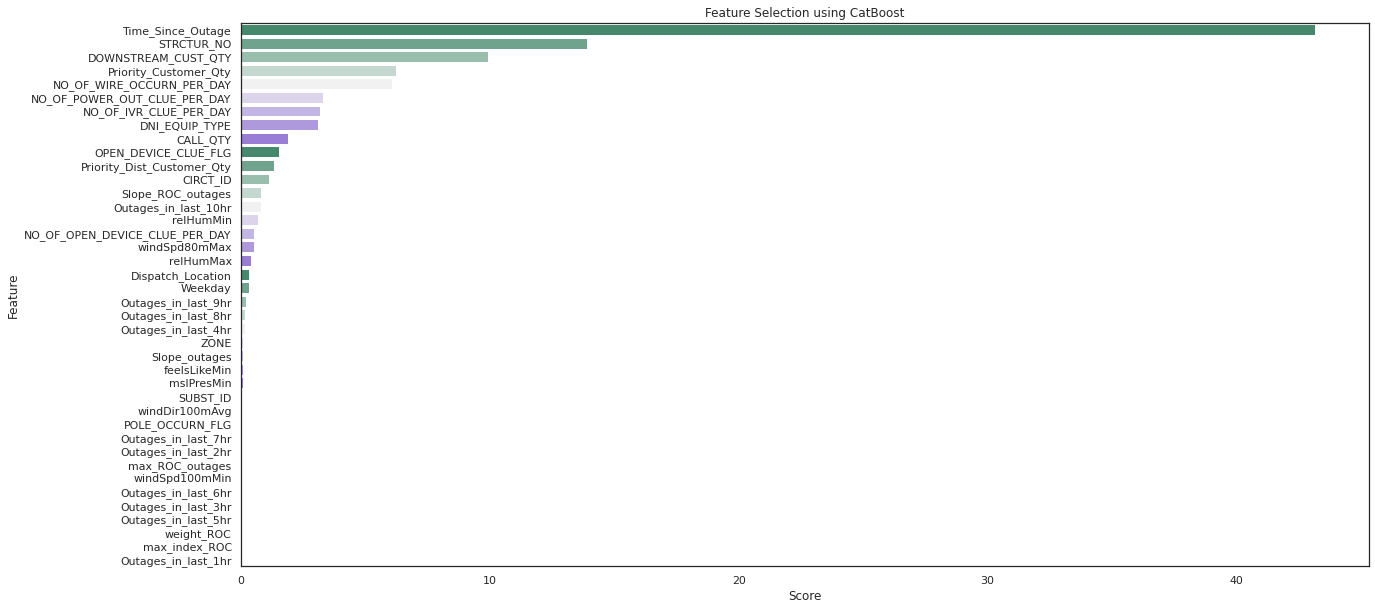

In [17]:
%time 

get_feature_imp_plot(method="PredictionValuesChange")

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.68 µs


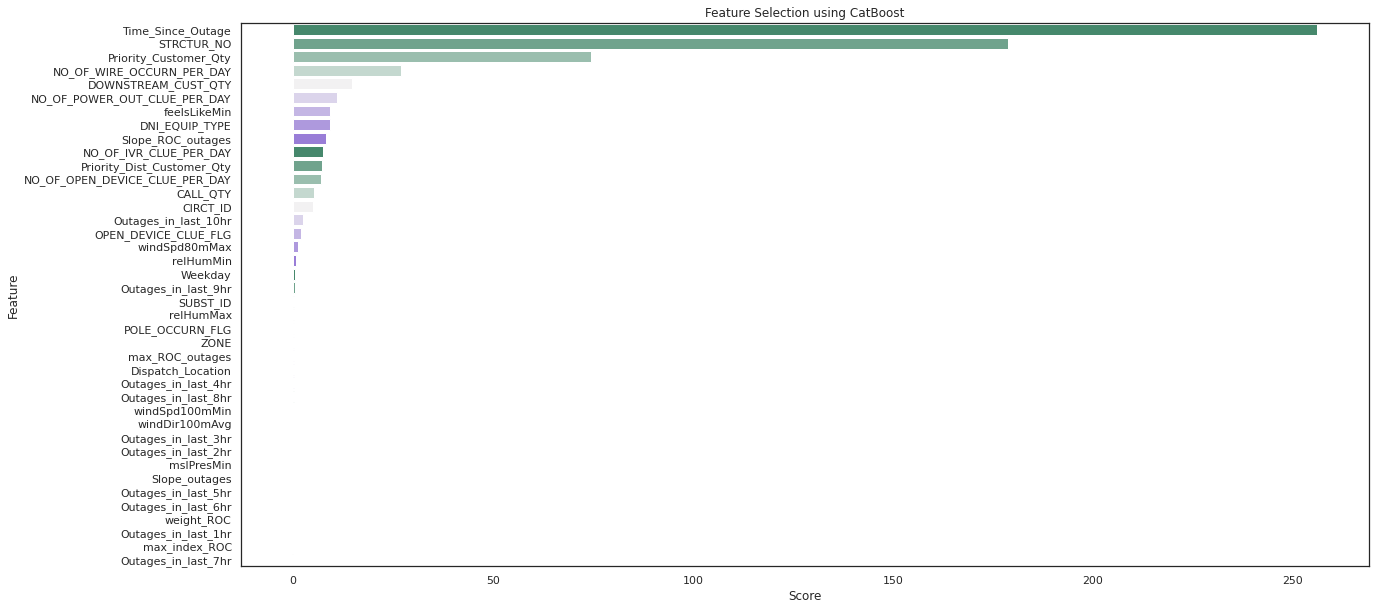

In [18]:
%time 
get_feature_imp_plot(method="LossFunctionChange")

#### **Group K fold Split using sklearn**

- K-fold iterator variant with non-overlapping groups. <br>
- The same group will not appear in two different folds (the number of distinct groups has to be at least equal to the number of folds). <br>
- The folds are approximately balanced in the sense that the number of distinct groups is approximately the same in each fold. <br>

In [19]:
# create hold out sample with separate groups 
X = load_ads
y = load_ads['TR']

groups = load_ads['OUTAGE_ID']
group_kfold = GroupKFold(n_splits=15)

for train_test_index, hold_index in group_kfold.split(X, y, groups):
    pass

print("TRAIN TEST INDEX:", train_test_index, "HOLDOUT INDEX:", hold_index)
print("TRAIN TEST INDEX:", len(train_test_index), "HOLDOUT INDEX:", len(hold_index))

X_train_test, X_hold = X.iloc[train_test_index], X.iloc[hold_index]
y_train_test, y_hold = y.iloc[train_test_index], y.iloc[hold_index]

TRAIN TEST INDEX: [     0      1      2 ... 488768 488769 488770] HOLDOUT INDEX: [    23     24     25 ... 488664 488665 488666]
TRAIN TEST INDEX: 456187 HOLDOUT INDEX: 32584


In [20]:
X = X_train_test
y = X_train_test['TR']

groups = X_train_test['OUTAGE_ID']
group_kfold = GroupKFold(n_splits=5)
group_kfold.get_n_splits(X, y, groups)

5

In [21]:
# creating variable with having only categorical features index
categorical_features_indices = np.where((X[final_features].dtypes != np.int) & (X[final_features].dtypes != np.float))[0];
print(categorical_features_indices)

# adding Substation id and Circuit id as categorical feature
arr1 = np.array([2, 36])
categorical_features_indices = np.append(arr1, categorical_features_indices)
print(categorical_features_indices)

[ 1  3  5 17 32 34 35]
[ 2 36  1  3  5 17 32 34 35]


#### **Randomized Search for optimal parameters using CatBoost**

Important Parameters which control overfitting 
- **learning rate** - The default value is defined automatically for Logloss, MultiClass & RMSE loss functions depending on the number of iterations if none of these parameters is set. In this case, the selected learning rate is printed to stdout and saved in the model. In other cases, the default value is 0.03. <br>
- **depth** - Depth of the tree. The range of supported values depends on the processing unit type and the type of the selected loss function: CPU — Any integer up to  16.
- **l2_leaf_reg** - Coefficient at the L2 regularization term of the cost function. Any positive value is allowed.
- **leaf_estimation_iterations** - CatBoost might calculate leaf values using several gradient or newton steps instead of a single one. This parameter regulates how many steps are done in every tree when calculating leaf values.

Parameters for categorical values
- **cat_features** - It denotes the index of categorical features
- **one_hot_max_size** - Use one hot encoding for all features with number of different values with less than or equal to the given parameter value (max - 255)

Parameters for controlling speed
- **rsm** - Random subspace method. The percentage of features to use at each split selection, when features are selected over again at random. The value must be in the range (0;1].
- **iteration** - The maximum number of trees that can be built when solving machine learning problems. When using other parameters that limit the number of iterations, the final number of trees may be less than the number specified in this parameter.

Overfitting detector settings 
- **early_stopping_rounds** - Sets the overfitting detector type to Iter and stops the training after the specified number of iterations since the iteration with the optimal metric value.

In [22]:
# parameter grid for randomized search 
grid_params = {'n_estimators': [int(x) for x in np.linspace(start = 1000, stop = 5000, num = 5)],
               'learning_rate': [x for x in np.linspace(start = 0.01, stop = 0.2, num = 20)],
               'depth': [int(x) for x in np.linspace(1, 10, num = 5)],
               'l2_leaf_reg': [int(x) for x in np.linspace(1, 10, num = 5)],
               'rsm': [int(x) for x in np.linspace(0.1, 1, num = 5)],
               'leaf_estimation_iterations': [None, 1, 2, 3, 4]}

grid_params

{'n_estimators': [1000, 2000, 3000, 4000, 5000],
 'learning_rate': [0.01,
  0.02,
  0.03,
  0.04,
  0.05,
  0.060000000000000005,
  0.06999999999999999,
  0.08,
  0.09,
  0.09999999999999999,
  0.11,
  0.12,
  0.13,
  0.14,
  0.15000000000000002,
  0.16,
  0.17,
  0.18000000000000002,
  0.19,
  0.2],
 'depth': [1, 3, 5, 7, 10],
 'l2_leaf_reg': [1, 3, 5, 7, 10],
 'rsm': [0, 0, 0, 0, 1],
 'leaf_estimation_iterations': [None, 1, 2, 3, 4]}

In [ ]:
# model declaration
cat_ran = CatBoostRegressor(silent=True, cat_features=categorical_features_indices, early_stopping_rounds=50, loss_function='MAE', eval_metric='RMSE')

# Randomized search using CatBoost Randmized Serch Implementation
randomized_search_result = cat_ran.randomized_search(grid_params, X=X[final_features], y=y, n_iter=1000, cv=group_kfold.split(X, y, groups), verbose=True)

Stopped by overfitting detector  (50 iterations wait)

bestTest = 637.556829
bestIteration = 71

0:	loss: 637.5568290	best: 637.5568290 (0)	total: 6.75s	remaining: 1h 52m 24s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 638.7658802
bestIteration = 174

1:	loss: 638.7658802	best: 637.5568290 (0)	total: 18.4s	remaining: 2h 32m 48s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 620.6896839
bestIteration = 21

2:	loss: 620.6896839	best: 620.6896839 (2)	total: 22.1s	remaining: 2h 2m 37s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 630.1483305
bestIteration = 66

3:	loss: 630.1483305	best: 620.6896839 (2)	total: 28.2s	remaining: 1h 57m 11s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 618.2519201
bestIteration = 331

4:	loss: 618.2519201	best: 618.2519201 (4)	total: 1m 7s	remaining: 3h 44m 14s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 616.7113923
bestIteration = 68

5:	loss: 616.7113923	b

In [ ]:
# randomized_search_result
df_results = pd.DataFrame(randomized_search_result.get('cv_results'))
df_results.head()

,iterations,test-RMSE-mean,test-RMSE-std,train-RMSE-mean,train-RMSE-std,test-MAE-mean,test-MAE-std,train-MAE-mean,train-MAE-std
0,0,3563.73,1727.56,3867.04,408.43,909.62,204.45,909.61,50.81
1,1,3545.75,1730.74,3851.57,408.64,881.52,204.04,881.51,50.69
2,2,3531.51,1731.14,3838.58,407.95,856.71,203.68,856.67,50.48
3,3,3525.32,1731.99,3831.76,408.08,846.17,203.53,845.90,50.35
4,4,3513.64,1731.47,3820.86,407.43,829.68,202.99,829.41,50.29


In [33]:
randomized_search_result.get('params')

{'leaf_estimation_iterations': 3,
 'rsm': 1,
 'depth': 1,
 'l2_leaf_reg': 10,
 'iterations': 4000,
 'learning_rate': 0.2}

In [49]:
cat_ran = CatBoostRegressor(silent=True, cat_features=categorical_features_indices, boost_from_average=True, early_stopping_rounds=50, loss_function='MAE', eval_metric='RMSE')
cat_ran.set_params(**randomized_search_result.get('params'))
cat_ran.fit(X[final_features], y, cat_features=categorical_features_indices, early_stopping_rounds=50)

#### **Saving Model Object**

In [50]:
import gcsfs

fs = gcsfs.GCSFileSystem(project='aes-datahub-0002')
fs.ls('aes-datahub-0002-curated/Outage_Restoration/Historical_Data/PickleFiles')
with fs.open('aes-datahub-0002-curated/Outage_Restoration/Historical_Data/PickleFiles/IPL_TTR_Catboost_12142020.pkl', 'wb') as f:
    pickle.dump(cat_ran, f)

In [51]:
model_col = ['MODEL_NAME' , 'TEST_MSE', 'TEST_RMSE', 'TEST_MAE', 'TEST_MAPE']
model_result_df = pd.DataFrame(columns=model_col)
data_test_list = pd.DataFrame() 
i=0

In [52]:
X = X_hold[final_features]
y = y_hold

y_test_pred = cat_ran.predict(X)

mse_test = mean_squared_error(y, y_test_pred)
rmse_test = rmse(y,y_test_pred)
mae_test = mean_absolute_error(y, y_test_pred)
mape_test = mean_absolute_percentage_error(y,y_test_pred)

data_test = pd.DataFrame({'Model':'CatBoost', 'Test_Predicted': list(y_test_pred),'Test_Actual': list(y)})
data_test_list = data_test_list.append(data_test)
data_test_list.reset_index(drop=True, inplace=True)

model_result_df.loc[i] = ['CatBoost', mse_test, rmse_test, mae_test, mape_test]
i = i + 1

In [53]:
model_result_df

,MODEL_NAME,TEST_MSE,TEST_RMSE,TEST_MAE,TEST_MAPE
0,CatBoost,151199.68,388.84,164.01,inf


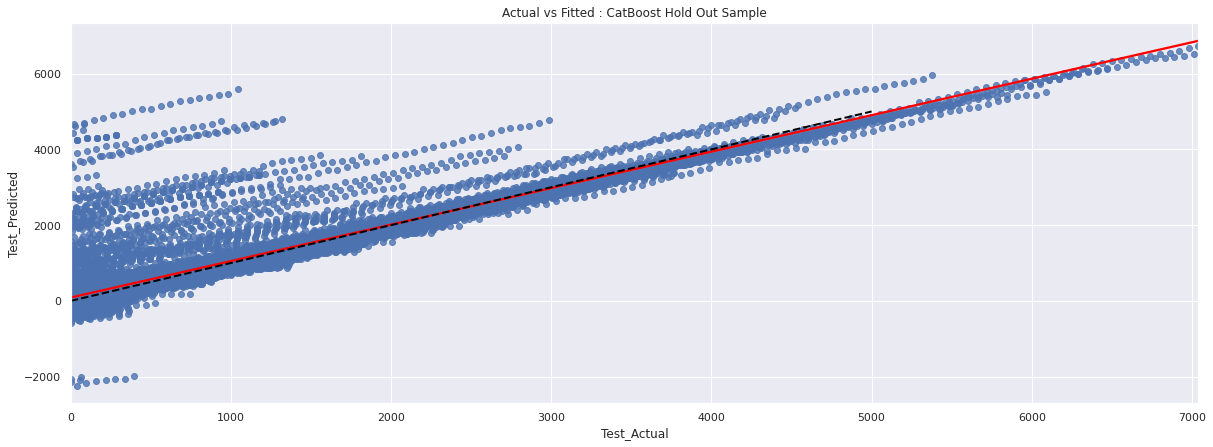

In [74]:
sns.set(rc={'figure.figsize':(18,7)})
sns.set_style("darkgrid")

ax = sns.regplot(x="Test_Actual", y="Test_Predicted", data=data_test_list[data_test_list.Model=='CatBoost'], line_kws={"color": "red"})
ax.set_title('Actual vs Fitted : CatBoost Hold Out Sample')
points = np.linspace(0, 5000, 100)
ax = sns.lineplot(points, points, color='black', marker=None,linestyle='--', linewidth=2.0)